# The demonstration of the tropical rainfall diagnostic for high-resolution data

### Content


1. [The load of packages, modules, and data](#1-load-of-packages-modules-and-data)

2. [Calculation of histograms]()

3. [Comparison of histograms](#2-comparison-of-histograms)

[Go to the end of file](#the-end)

We split the function to calculate the histogram and the demonstration because the initial function to calculate the histogram has a big memory overhead, and this overhead is significant for high-resolution data. 

The histogram calculations for low-resolution data have more features. Namely, the description of the functionality is following:

|  | Low-resolution | High-resolution |
| --- | --- | --- |
| name of function | histogram_lowres   | histogram|
| uniform binning | + | + |
| non-uniform (log-spaced) binning | + | - |
| lazy (or delayed) mode | + | - |
|  weights (weights=reader.grid_area) | + | - |

In the following deliverable of the diagnostic, we will provide the unique function for data with any grid that wil contain all necessary features for high-resolution data (like non-uniform binning).

#

## 1. The load of packages, modules, and data

In [1]:
import sys
from aqua import Reader
sys.path.insert(0, '../../')
from tropical_rainfall import Tropical_Rainfall

In [2]:
from aqua.slurm import slurm

##### Initialization of the diagnostic

In [3]:
# Please change the path to the NetCDF files and the PDF files to your own path

path_to_netcdf = "/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/"
path_to_mean = "/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/mean/"
path_to_pdf    = "/work/bb1153/b382267/tropical_rainfall_cicle3/PDF/"

In [ ]:
slurm.job(cores=16, memory="250 GB")

In [6]:
slurm.squeue()

JOBID      CPUS  NODES ST         NAME                 TIME       START_TIME           DEPENDENCY           PARTITION            MIN_MEMORY          
6956745    256   1     R          dask-worker          0:46       2023-09-20T17:58:21  (null)               compute              233G                


0

#### ICON, ngc3028, lra

##### For big datasets, it is better to calculate and store the histograms by months instead of the full-time range of the dataset. 

The main reasons for that are the following:
- The user can easily keep track of precipitation from a specific season. 
- To keep calculations safe from Runtime errors and memory issues. 

In the current stage of tropical-rainfall diagnostics, we use a streaming-aqua mode in order to split the input data over months. 

#### IFS, tco1279-orca025-cycle3

The bottleneck in the histogram calculation is the necessity to regrid the data and modify the frequency of the original data. 

In [2]:
diag = Tropical_Rainfall(trop_lat=15,  num_of_bins = 1000, first_edge = 0, width_of_bin = 1 - 10**(-6), loglevel='debug')

In [ ]:
reader              = Reader(model="IFS", exp="tco1279-orca025-cycle3", source="2D_1h_native", regrid="r010")
ifs_tco1279_orca025_retrived = reader.retrieve()
#ifs_tco1279_orca025_retrived=ifs_tco1279_orca025_retrived.isel(time=slice(1,-1))

In [18]:
for year in range(2020, 2026):
    for x in range(1, 12, 2):
        ifs_tco1279_orca025 = ifs_tco1279_orca025_retrived.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        ifs_tco1279_orca025 = reader.timmean(ifs_tco1279_orca025, freq="3H")
        ifs_tco1279_orca025 = reader.regrid(ifs_tco1279_orca025)
        diag.histogram(ifs_tco1279_orca025, path_to_histogram=path_to_netcdf, threshold = 30, 
                     name_of_file="ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h")

In [ ]:
for year in range(2020, 2026):
    for x in range(1, 12):
        
        ifs_tco1279_orca025 = ifs_tco1279_orca025_retrived.sel(time=str(year)+'-'+str(x))
        ifs_tco1279_orca025 = reader.timmean(ifs_tco1279_orca025, freq="3H")
        ifs_tco1279_orca025 = reader.regrid(ifs_tco1279_orca025)
        diag.trop_lat = 90
        diag.s_month, diag.f_month = None, None
        diag.average_into_netcdf(ifs_tco1279_orca025, coord='lon', trop_lat=90,
                         path_to_netcdf=path_to_mean,  name_of_file='ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h')
        diag.trop_lat = 15
        diag.s_month, diag.f_month = None, None
        diag.average_into_netcdf(ifs_tco1279_orca025, coord='lat', trop_lat=15,
                         path_to_netcdf=path_to_mean,  name_of_file='ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h')

#### IFS, tco2559_ng5

In [ ]:
reader                      = Reader(model="IFS", exp="tco2559-ng5-cycle3", source="2D_1h_native")
data_ifs_tco2559_ng5_ret    = reader.retrieve()

In [ ]:
reader                      = Reader(model="IFS", exp="tco2559-ng5-cycle3", source="2D_1h_native",  regrid="r010")
data_ifs_tco2559_ng5_ret    = reader.retrieve()

path_to_netcdf = '/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/tco2559-ng5-cycle3/'
for year in range(2020, 2026):
    for x in range(1, 12, 2):
        data_ifs_tco2559_ng5 = data_ifs_tco2559_ng5_ret.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        data_ifs_tco2559_ng5 = reader.timmean(data_ifs_tco2559_ng5, freq="3H")
        data_ifs_tco2559_ng5 = reader.regrid(data_ifs_tco2559_ng5)
        data_ifs_tco2559_ng5  = data_ifs_tco2559_ng5['tprate'][:]*86400
        diag.histogram(data_ifs_tco2559_ng5, path_to_histogram=path_to_netcdf, threshold = 10, 
                     name_of_file="ifs_tco1279_orca025_3hourly_2D_1h_native_r010_3h")

#### ICON

In [ ]:
reader = Reader(model="ICON", exp="ngc3028", source="PT3H", zoom=10,  regrid="r010")
data_icon3028_retrieved = reader.retrieve()

path_to_netcdf ="/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/PT3H/"

for year in range(2020, 2026):
    for x in range(1, 12, 2):
        data_icon3028 = data_icon3028_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        data_icon3028 = data_icon3028['tprate'][:]*86400
        data_icon3028 = reader.regrid(data_icon3028)
        diag.histogram(data_icon3028, path_to_histogram=path_to_netcdf, 
                     name_of_file="icon3028_tco1279_PT3H_r010_3h")

### MSWEP no fixer

In [4]:
diag = Tropical_Rainfall(trop_lat=15,  num_of_bins = 1000, first_edge = 0, width_of_bin = 1, loglevel='debug')

In [ ]:
reader        = Reader(model="MSWEP", exp="past", source="3hourly")
mswep_no_fixer = reader.retrieve(fix=False)
mswep_no_fixer = mswep_no_fixer.rename({'precipitation': 'tprate'})
path_to_netcdf = "/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_no_fixer/"

for year in range(1979, 2020):
    for x in range(1, 12, 2):
        
        mswep  = mswep_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        mswep   = mswep['tprate'][:]*8
        mswep.attrs['units'] = "mm/day"
        diag.histogram(mswep, path_to_histogram=path_to_netcdf, 
                     name_of_file="trop_rainfall_mswep_past_3hourly_r010")


### MSWEP with fixer

In [3]:
diag = Tropical_Rainfall(trop_lat=15,  num_of_bins = 1000, first_edge = 0, width_of_bin = 1 - 10**(-6), loglevel='debug')

In [ ]:

reader              = Reader(model="IFS", exp="tco2559-ng5", source="ICMU_atm2d")
mswep_retrieved     = reader.retrieve()


In [ ]:
reader              = Reader(model="MSWEP", exp="past", source="3hourly")
mswep_retrieved     = reader.retrieve()

path_to_netcdf      ="/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_new_fixer/"

for year in range(1979, 2020):
    for x in range(1, 12, 2):
        
        mswep  = mswep_retrieved.sel(time=slice(str(year)+'-'+str(x), str(year)+'-'+str(x+1)))
        mswep   = mswep['tprate'][:]*86400
        mswep.attrs['units'] = "mm/day"
        diag.histogram(mswep, path_to_histogram=path_to_netcdf, 
                     name_of_file="trop_rainfall_mswep_past_3hourly_r010")

In [19]:
#era5_1950_1959 = era5_1950_1959.rename({'latitude': 'lat'})
#era5_1950_1959 = era5_1950_1959.rename({'longitude': 'lon'})
#era5_1950_1959 = era5_1950_1959.rename({'tp': 'tprate'})

In [11]:
#ds_hist = xr.open_dataset('/work/bb1153/b382267/Observations_Zarr/ERA5/1H_1950_1959/zarr/hists/trop_rainfall_1950-01_1949-12-31T06_1950-01-31T18_histogram.nc')

In [7]:
import xarray as xr
ds_zarr = xr.open_dataset('/work/bb1153/b382267/Observations_Zarr/ERA5/1H_1950_1959/zarr/'+str(1950)+'/'+str(1950)+'-01_new.zarr')

/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [ ]:
import xarray as xr
for year in range(1950, 1959):
    for month in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
        ds = xr.open_dataset('/work/bb1153/b382267/Observations_Zarr/ERA5/1H_1950_1959/zarr/'+str(year)+'/'+str(year)+'-'+month+'_new.zarr')
        ds = diag.latitude_band(ds)
        ds = ds*86400
        ds.tp.attrs['units'] = 'mm/day'

        diag.histogram(ds.tp,  path_to_histogram='/work/bb1153/b382267/Observations_Zarr/ERA5/1H_1950_1959/zarr/hists/', name_of_file=str(year)+'-'+month)

In [ ]:
path_to_era5='/work/bb1153/b382267/Observations_Zarr/ERA5/1H_1950_1959/zarr/hists/'
hist_era5 = diag.merge_list_of_histograms(path_to_histograms = path_to_era5,  all = True)

In [5]:
hist_era5 

<xarray.Dataset>
Dimensions:        (center_of_bin: 1000)
Coordinates:
  * center_of_bin  (center_of_bin) float64 0.5 1.5 2.5 3.5 ... 997.5 998.5 999.5
    width          (center_of_bin) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Data variables:
    counts         (center_of_bin) float64 5.633e+09 7.824e+08 ... 5.847e+03
    frequency      (center_of_bin) float64 0.1597 0.02218 ... 1.657e-07
    pdf            (center_of_bin) float64 0.1597 0.02218 ... 1.657e-07
Attributes: (12/25)
    GRIB_N:                          320
    GRIB_NV:                         0
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  tp
    GRIB_gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    GRIB_gridType:                   reduced_gg
    ...                              ...
    time_band:                       1949-12-31T06:00:00.000000000, 1950-01-3...
    lat_band:                        14.754093763021956, -14.754093763021956,...
    lon_band:                        0.0, 359.71875, freq=0.28125
    mean_of_original_data:           15.057234722062066;\n 16.065044010941673...
    mean_of_histogram:               5.082794989861305;\n 5.441222884145694;\...
    relative_discrepancy:            66.24350298256343;\n 66.13004682439865;\...

In [7]:
diag.dataset_to_netcdf(hist_era5, path_to_netcdf='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ERA5/', name_of_file='era5_1950-1959')

2023-09-20 20:11:22 :: create_folder :: WARNING  -> Folder /work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ERA5/ already exists
2023-09-20 20:11:22 :: Trop. Rainfall :: INFO     -> NetCDF is saved in the storage.


'/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/ERA5/trop_rainfall_era5_1950-1959_1949-12-31T06_1950-01-31T18_histogram.nc'

In [ ]:
#min_lat = -15
##max_lat = 15
#ds_regridded.where(
#    (ds_regridded['lat'] <= max_lat), drop=True
#)

In [ ]:

#reader              = Reader(model="ERA5", exp="era5-dkrz", source="daily_inst", regrid="r010")
#era5 = reader.retrieve()

In [ ]:
era5

In [59]:
#reader   = Reader(model="ERA5", exp="era5", source="tp_nc")
#era5     = reader.retrieve()

reader              = Reader(model="ERA5", exp="era5", source="tp_zarr_hourly", regrid="r010")
era5 = reader.retrieve(apply_unit_fix=False)
era5 = era5.rename({'time': 'old_time'})
era5 = era5.rename({'valid_time': 'time'})
era5 = reader.timmean(era5, freq="3H")
era5 = reader.regrid(era5)
#ifs_tco1279_orca025 = reader.timmean(ifs_tco1279_orca025, freq="3H")
#ifs_tco1279_orca025 = reader.regrid(ifs_tco1279_orca025)

2023-09-21 20:23:54 :: Reader :: WARNING  -> No default fixes found! No fixes available for model ERA5, experiment era5, source tp_zarr_hourly
/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
2023-09-21 20:23:54 :: Reader :: WARNING  -> Duplicate entries found along the time axis, keeping the first one.
/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/core/dataset.py:6037: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    .

In [71]:
temp = era5.drop(['old_time', 'step'])
temp.time
#time.values = era5.ti
era5['time'] = (('old_time', 'step'), era5.time.values)
temp = era5.drop(['old_time', 'step'])

In [72]:
temp.time

<xarray.DataArray 'time' (old_time: 63, step: 24)>
array([['1949-12-31T07:00:00.000000000', '1949-12-31T08:00:00.000000000',
        '1949-12-31T09:00:00.000000000', ...,
        '1950-01-01T04:00:00.000000000', '1950-01-01T05:00:00.000000000',
        '1950-01-01T06:00:00.000000000'],
       ['1950-01-01T07:00:00.000000000', '1950-01-01T08:00:00.000000000',
        '1950-01-01T09:00:00.000000000', ...,
        '1950-01-02T04:00:00.000000000', '1950-01-02T05:00:00.000000000',
        '1950-01-02T06:00:00.000000000'],
       ['1950-01-01T19:00:00.000000000', '1950-01-01T20:00:00.000000000',
        '1950-01-01T21:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['1950-01-30T19:00:00.000000000', '1950-01-30T20:00:00.000000000',
        '1950-01-30T21:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['1950-01-31T07:00:00.000000000', '1950-01-31T08:00:00.000000000',
        '1950-01-31T09:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['1950-01-31T19:00:00.000000000', '1950-01-31T20:00:00.000000000',
        '1950-01-31T21:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
    number   int64 ...
    surface  float64 ...
    time     (old_time, step) datetime64[ns] 1949-12-31T07:00:00 ... NaT
Dimensions without coordinates: old_time, step

In [ ]:
time: 63step: 24values: 542080

In [19]:
temp  = era5.step.values

In [20]:
import numpy as np
[np.datetime64(int(temp[i]), 'ns') for i in range(0, len(temp))]

[numpy.datetime64('1970-01-01T01:00:00.000000000'),
 numpy.datetime64('1970-01-01T02:00:00.000000000'),
 numpy.datetime64('1970-01-01T03:00:00.000000000'),
 numpy.datetime64('1970-01-01T04:00:00.000000000'),
 numpy.datetime64('1970-01-01T05:00:00.000000000'),
 numpy.datetime64('1970-01-01T06:00:00.000000000'),
 numpy.datetime64('1970-01-01T07:00:00.000000000'),
 numpy.datetime64('1970-01-01T08:00:00.000000000'),
 numpy.datetime64('1970-01-01T09:00:00.000000000'),
 numpy.datetime64('1970-01-01T10:00:00.000000000'),
 numpy.datetime64('1970-01-01T11:00:00.000000000'),
 numpy.datetime64('1970-01-01T12:00:00.000000000'),
 numpy.datetime64('1970-01-01T13:00:00.000000000'),
 numpy.datetime64('1970-01-01T14:00:00.000000000'),
 numpy.datetime64('1970-01-01T15:00:00.000000000'),
 numpy.datetime64('1970-01-01T16:00:00.000000000'),
 numpy.datetime64('1970-01-01T17:00:00.000000000'),
 numpy.datetime64('1970-01-01T18:00:00.000000000'),
 numpy.datetime64('1970-01-01T19:00:00.000000000'),
 numpy.datet

In [ ]:
era5['valid_time'].stack(flat_dim=['dim'])

In [43]:
era5

<xarray.Dataset>
Dimensions:     (step: 24, time: 63, lat: 1800, lon: 3600)
Coordinates:
    number      int64 ...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * time        (time) datetime64[ns] 1949-12-31T06:00:00 ... 1950-01-31T18:0...
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(63, 24), meta=np.ndarray>
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon         (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
Data variables:
    tp          (time, step, lat, lon) float64 dask.array<chunksize=(5, 3, 1800, 3600), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-09-15T18:18 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [55]:
era5['tp']['valid_time'].values

/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


array([['1949-12-31T07:00:00.000000000', '1949-12-31T08:00:00.000000000',
        '1949-12-31T09:00:00.000000000', ...,
        '1950-01-01T04:00:00.000000000', '1950-01-01T05:00:00.000000000',
        '1950-01-01T06:00:00.000000000'],
       ['1950-01-01T07:00:00.000000000', '1950-01-01T08:00:00.000000000',
        '1950-01-01T09:00:00.000000000', ...,
        '1950-01-02T04:00:00.000000000', '1950-01-02T05:00:00.000000000',
        '1950-01-02T06:00:00.000000000'],
       ['1950-01-01T19:00:00.000000000', '1950-01-01T20:00:00.000000000',
        '1950-01-01T21:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['1950-01-30T19:00:00.000000000', '1950-01-30T20:00:00.000000000',
        '1950-01-30T21:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['1950-01-31T07:00:00.000000000', '19

In [48]:
#new_era5 = era5['tp'].stack(new_time = ['valid_time']) #'time', 'step'])  #flat_dim = ['valid_time']
import xarray as xr
flattened_dataarray = xr.concat([era5['tp']['valid_time'][i] for i in range(len(era5['tp']['time']))], dim='time')


/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [51]:
#flattened_dataarray.values

#Drop 'NaT' values (NaN values in case of lists)
flattened_dataarray = flattened_dataarray.dropna(dim='time')


/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [52]:
flattened_dataarray

<xarray.DataArray 'valid_time' (time: 2, step: 24)>
dask.array<getitem, shape=(2, 24), dtype=datetime64[ns], chunksize=(1, 24), chunktype=numpy.ndarray>
Coordinates:
    number      int64 ...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00
    surface     float64 ...
  * time        (time) datetime64[ns] 1949-12-31T06:00:00 1950-01-01T06:00:00
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(1, 24), meta=np.ndarray>
Attributes:
    long_name:      time
    standard_name:  time

In [39]:
new_era5.new_time

<xarray.DataArray 'new_time' (new_time: 1512)>
array([(Timestamp('1949-12-31 06:00:00'), Timedelta('0 days 01:00:00')),
       (Timestamp('1949-12-31 06:00:00'), Timedelta('0 days 02:00:00')),
       (Timestamp('1949-12-31 06:00:00'), Timedelta('0 days 03:00:00')), ...,
       (Timestamp('1950-01-31 18:00:00'), Timedelta('0 days 22:00:00')),
       (Timestamp('1950-01-31 18:00:00'), Timedelta('0 days 23:00:00')),
       (Timestamp('1950-01-31 18:00:00'), Timedelta('1 days 00:00:00'))],
      dtype=object)
Coordinates:
    number      int64 ...
    surface     float64 ...
    valid_time  (new_time) datetime64[ns] dask.array<chunksize=(1512,), meta=np.ndarray>
  * new_time    (new_time) object MultiIndex
  * time        (new_time) datetime64[ns] 1949-12-31T06:00:00 ... 1950-01-31T...
  * step        (new_time) timedelta64[ns] 01:00:00 02:00:00 ... 1 days 00:00:00

In [24]:
temp = era5.valid_time.values

/work/bb1153/b382267/mamba_dir/mambaforge/envs/common_environment/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [26]:
temp[0]

array(['1949-12-31T07:00:00.000000000', '1949-12-31T08:00:00.000000000',
       '1949-12-31T09:00:00.000000000', '1949-12-31T10:00:00.000000000',
       '1949-12-31T11:00:00.000000000', '1949-12-31T12:00:00.000000000',
       '1949-12-31T13:00:00.000000000', '1949-12-31T14:00:00.000000000',
       '1949-12-31T15:00:00.000000000', '1949-12-31T16:00:00.000000000',
       '1949-12-31T17:00:00.000000000', '1949-12-31T18:00:00.000000000',
       '1949-12-31T19:00:00.000000000', '1949-12-31T20:00:00.000000000',
       '1949-12-31T21:00:00.000000000', '1949-12-31T22:00:00.000000000',
       '1949-12-31T23:00:00.000000000', '1950-01-01T00:00:00.000000000',
       '1950-01-01T01:00:00.000000000', '1950-01-01T02:00:00.000000000',
       '1950-01-01T03:00:00.000000000', '1950-01-01T04:00:00.000000000',
       '1950-01-01T05:00:00.000000000', '1950-01-01T06:00:00.000000000'],
      dtype='datetime64[ns]')

In [28]:
temp[2]

array(['1950-01-01T19:00:00.000000000', '1950-01-01T20:00:00.000000000',
       '1950-01-01T21:00:00.000000000', '1950-01-01T22:00:00.000000000',
       '1950-01-01T23:00:00.000000000', '1950-01-02T00:00:00.000000000',
       '1950-01-02T01:00:00.000000000', '1950-01-02T02:00:00.000000000',
       '1950-01-02T03:00:00.000000000', '1950-01-02T04:00:00.000000000',
       '1950-01-02T05:00:00.000000000', '1950-01-02T06:00:00.000000000',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT'],
      dtype='datetime64[ns]')

In [29]:
temp[3]

array(['1950-01-02T07:00:00.000000000', '1950-01-02T08:00:00.000000000',
       '1950-01-02T09:00:00.000000000', '1950-01-02T10:00:00.000000000',
       '1950-01-02T11:00:00.000000000', '1950-01-02T12:00:00.000000000',
       '1950-01-02T13:00:00.000000000', '1950-01-02T14:00:00.000000000',
       '1950-01-02T15:00:00.000000000', '1950-01-02T16:00:00.000000000',
       '1950-01-02T17:00:00.000000000', '1950-01-02T18:00:00.000000000',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT',
                                 'NaT',                           'NaT'],
      dtype='datetime64[ns]')

## 2. Comparison of histograms

In [6]:
path_to_ifs='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/tco2559-ng5-cycle3/'
hist_ifs_2559 = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs,  all = True)

2023-07-19 02:39:07 :: Trop. Rainfall :: INFO     -> Histograms are merged.


In [7]:
path_to_ifs_orca='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/tco1279-orca025-cycle3/'
hist_ifs_tco1279 = diag.merge_list_of_histograms(path_to_histograms = path_to_ifs_orca, all = True)

2023-07-19 02:39:31 :: Trop. Rainfall :: INFO     -> Histograms are merged.


In [9]:
path_to_icon='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/PT3H/'
hist_icon_ngc3028 = diag.merge_list_of_histograms(path_to_histograms = path_to_icon,   all = True)

2023-07-19 02:43:27 :: Trop. Rainfall :: INFO     -> Histograms are merged.


## MSWEP check

In [14]:
path_to_mswep='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_no_fix/'
hist_mswep_no_fix = diag.merge_list_of_histograms(path_to_histograms = path_to_mswep,  all = True)

2023-07-20 17:27:02 :: Trop. Rainfall :: INFO     -> Histograms are merged.


### Fixer with new binning: width_of_bin = 1 - 10**(-6)

In [17]:
path_to_mswep='/work/bb1153/b382267/tropical_rainfall_cicle3/NetCDF/histograms/mswep_new_bins/'
hist_mswep_new_bins = diag.merge_list_of_histograms(path_to_histograms = path_to_mswep,  all = True)

2023-07-20 17:38:26 :: Trop. Rainfall :: INFO     -> Histograms are merged.


2023-07-19 02:56:48 :: create_folder :: WARNING  -> Folder /work/bb1153/b382267/tropical_rainfall_cicle3/PDF/ already exists


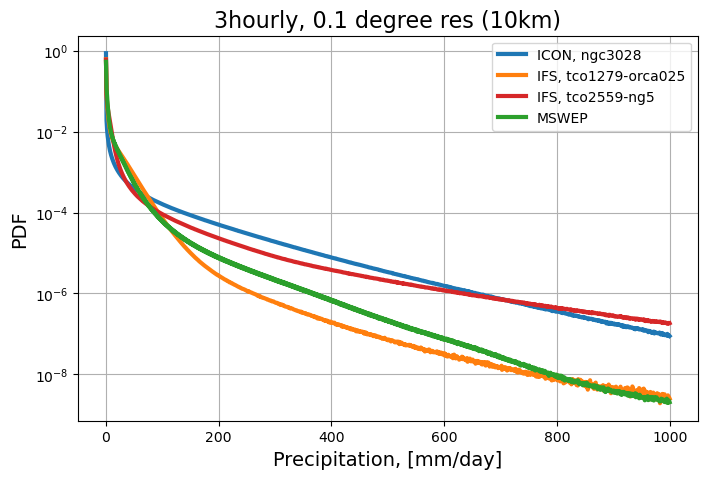

In [12]:
add = diag.histogram_plot(hist_icon_ngc3028,   pdf=True,   figsize=1,                         
                legend='ICON, ngc3028')
add = diag.histogram_plot(hist_ifs_tco1279.pdf,    pdf=False, frequency=False,   add = add,  color ='tab:orange', 
                legend='IFS, tco1279-orca025') 
add = diag.histogram_plot(hist_ifs_2559,       pdf=True,   add = add,  color ='tab:red', 
                legend='IFS, tco2559-ng5') 
add = diag.histogram_plot(hist_mswep,          pdf=True,   add = add,  color ='tab:green', 
                legend='MSWEP', 
                plot_title='3hourly, 0.1 degree res (10km)', loc='upper right',
                path_to_pdf=path_to_pdf, 
                pdf_format=False,  
                name_of_file='icon_ngc3028_ifs_tco2559_ng5_ifs_tco1279_orca025_mswep_10km_3h')

#

## Check how the diversity of histograms changes with time. 

##### The end